<a href="https://colab.research.google.com/github/NikhitapHegde/final_year_project/blob/main/generating_images_using_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [17]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()


KeyboardInterrupt: 

In [64]:
import zipfile
import os

# Define the name of the uploaded ZIP file
zip_file_name = 'archive (7).zip'  # Change this if your file has a different name

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

print("Files extracted to: extracted_files/")


Files extracted to: extracted_files/


In [65]:
NOISE_DIM = 100
BATCH_SIZE = 4
STEPS_PER_EPOCH = 100
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

MAIN_DIR = 'extracted_files/brain_tumor_dataset'

In [66]:
def load_images(folder):

    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

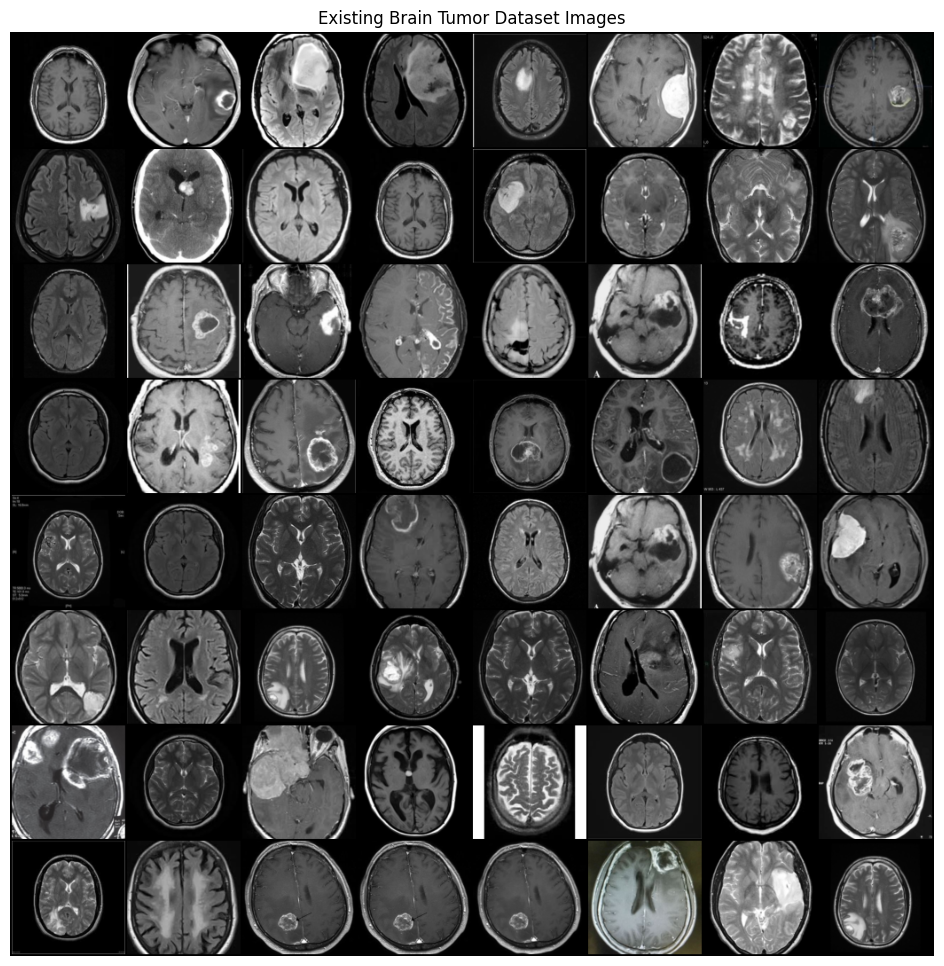

In [67]:
import os
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# === Dataset and Transformation Settings ===
dataroot = 'extracted_files/brain_tumor_dataset'  # Path to the extracted dataset
image_size = 128  # Resolution of the images
batch_size = 64
nc = 3  # Number of channels (3 for RGB images)

# === Dataset Transformation and Loading ===
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalization
])

# Load dataset
dataset = dset.ImageFolder(root=dataroot, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# === Function to Display Images ===
def show_images(images, nrow=8, title="Existing Images"):
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images, nrow=nrow, padding=2, normalize=True), (1, 2, 0)))
    plt.show()

# === Display a Batch of Existing Images ===
data_iter = iter(dataloader)
images, _ = next(data_iter)  # Get the first batch
show_images(images, nrow=8, title="Existing Brain Tumor Dataset Images")


In [68]:
NOISE_DIM = 100
BATCH_SIZE = 4
STEPS_PER_EPOCH = 3750
EPOCHS = 1
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

MAIN_DIR = 'extracted_files/brain_tumor_dataset/yes'

Loading and pre-processing of images

In [69]:
def load_images(folder):

    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

In [70]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((155, 128, 128), (155,))

In [71]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 20)

In [72]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

Normalizing

In [73]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(20, 128, 128, 1)

Plotting real images

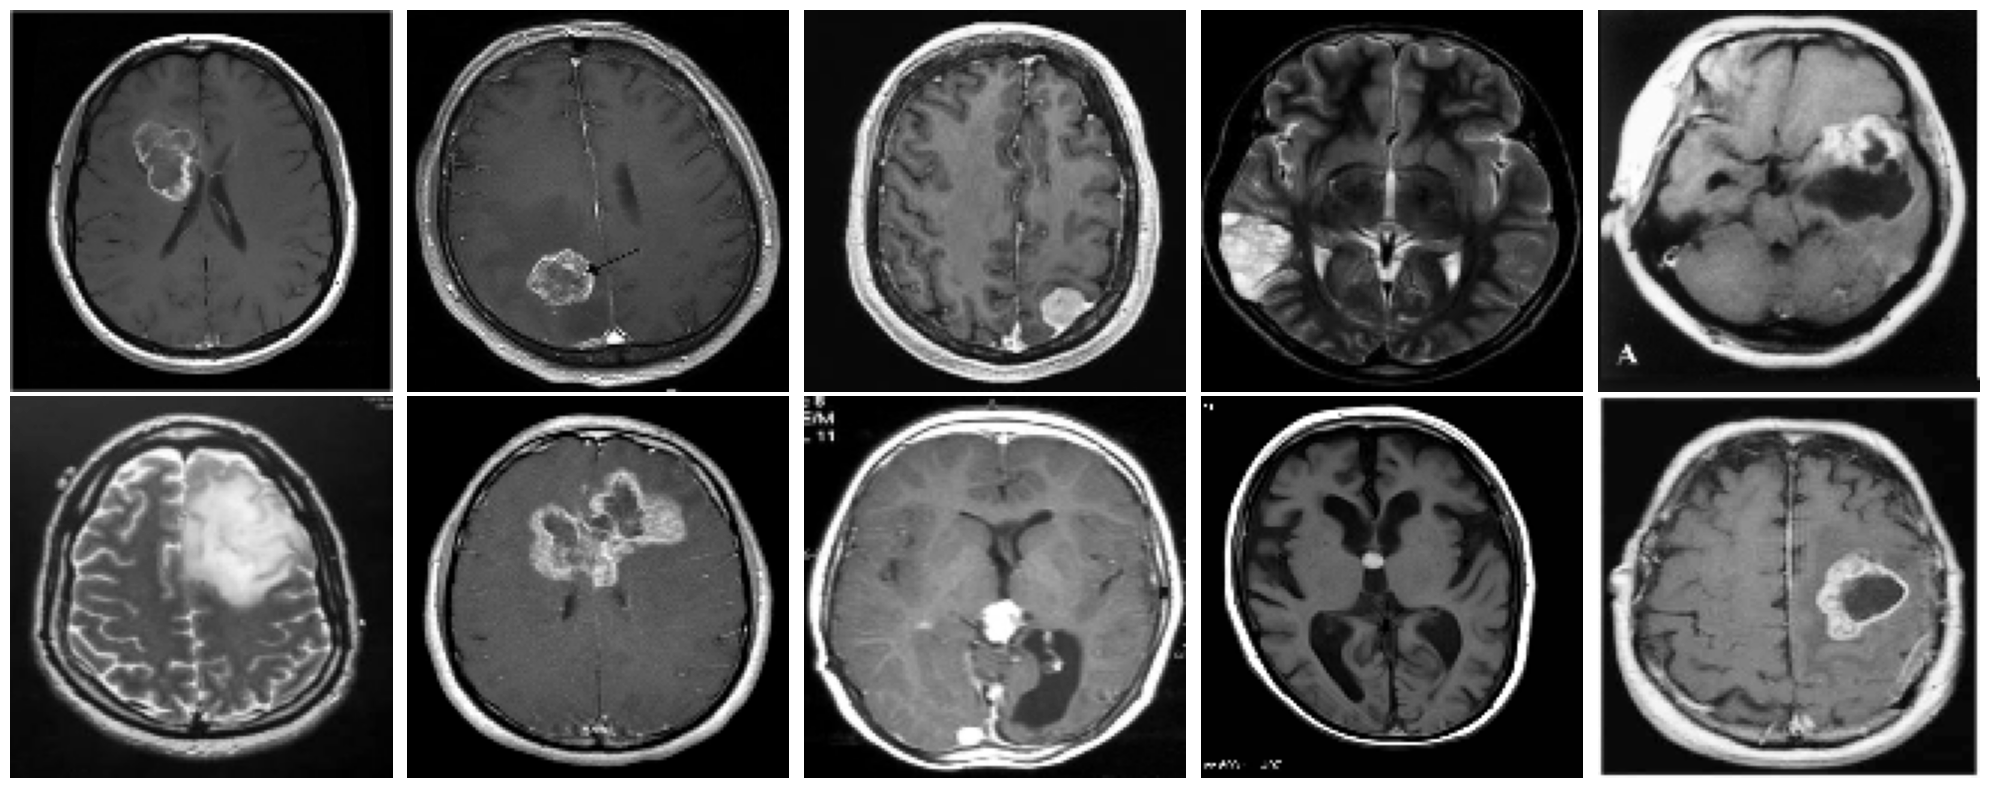

In [74]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [75]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ],
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [76]:
def build_discriminator():

    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

In [8]:
# Generate and Save 5 High-Resolution Images
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

# Set high resolution for generator output
HIGH_RES_WIDTH = 512
HIGH_RES_HEIGHT = 512

def build_generator_high_res():
    model = Sequential(name="Generator_HighRes")
    model.add(Dense(256 * (HIGH_RES_WIDTH // 4) * (HIGH_RES_HEIGHT // 4), activation="relu", input_dim=NOISE_DIM))
    model.add(Reshape((HIGH_RES_WIDTH // 4, HIGH_RES_HEIGHT // 4, 256)))
    model.add(Conv2DTranspose(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2DTranspose(CHANNELS, kernel_size=3, strides=1, padding="same", activation="tanh"))
    return model

# Replace generator with the high-resolution generator
generator = build_generator_high_res()

for i in range(5):  # Generate only 5 images
    noise = np.random.normal(0, 1, size=(1, NOISE_DIM))
    generated_image = generator.predict(noise)
    generated_image = ((generated_image[0] + 1) * 127.5).astype(np.uint8)  # Rescale to [0, 255]
    generated_image = cv2.cvtColor(generated_image, cv2.COLOR_GRAY2RGB) if CHANNELS == 1 else generated_image
    cv2.imwrite(os.path.join(output_dir, f"generated_{i + 1}_high_res.png"), generated_image)

print(f"Generated 5 high-resolution images saved in '{output_dir}'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Generated 5 high-resolution images saved in 'generated_images'


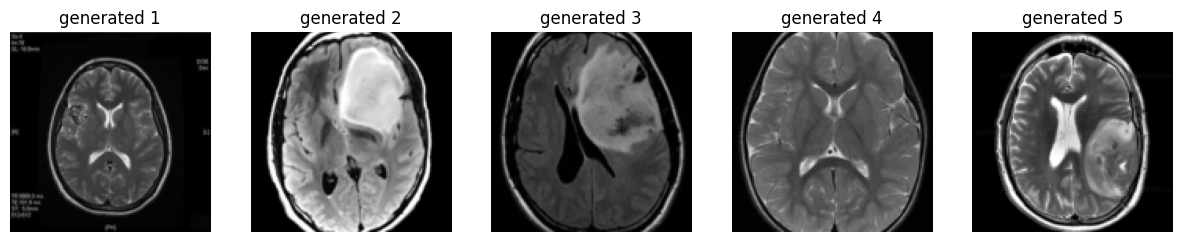

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as dset

# Define image loading and transformation
MAIN_DIR = 'extracted_files/brain_tumor_dataset'
image_size = 128  # Resolution of images

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the dataset
dataset = dset.ImageFolder(root=MAIN_DIR, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

# === Function to Display Original Images ===
def show_original_images(original_images, nrow=5):
    fig, axs = plt.subplots(nrows=1, ncols=nrow, figsize=(15, 6))

    # Display Original Images
    for i in range(nrow):
        axs[i].imshow(original_images[i])  # Show the color image
        axs[i].axis('off')
        axs[i].set_title(f"generated {i+1}")

    plt.show()

# === Load a Batch of Original Images ===
data_iter = iter(dataloader)
real_X, _ = next(data_iter)

# Denormalize and convert to numpy array for displaying
real_X = real_X.numpy().transpose((0, 2, 3, 1)) * 127.5 + 127.5  # Denormalize from [-1, 1] to [0, 255]
real_X = np.clip(real_X, 0, 255).astype(np.uint8)  # Clip values to be in [0, 255]

# Display the original images
show_original_images(real_X)
